# <font color='#2B4865'>**Hugging Face 🤗 Transformers Tutorial I**</font>

---
### Natural Language Processing
Date: Dec 21, 2022

Last Update: Nov 25, 2023

Author: Lorena Calvo-Bartolomé (lcalvo@pa.uc3m.es)

Version 1.1

---
This notebook is based on the [Hugging Face course](https://huggingface.co/course/chapter1/1), documentation available at the Hugging Face website and  [CS224n](https://web.stanford.edu/class/cs224n/)'s Hugging Face Transformers Tutorial session by Ben Newman.

It constitutes the first out of three tutorial notebooks on the usage of Hugging Face libraries as well as its application for solving a series of NLP tasks.

This notebook provides an introduction to the Hugging Face 🤗 Python library. In particular, its **goals** are:

*  To establish a common pattern for performing inference with Hugging Face Transformer models
*  To revise the specific fine-tuning example on the task of Sentiment Analysis

---

<font color='#E0144C'>**For this notebook's execution, we highly encourage you to use Google Colaboratory. While for the inference part it is not necessary, you will highly speed up the execution if you make use of a GPU. For doing so, follow the following steps:**</font>

<font color='#E0144C'>**1. Connect to hosted runtime**</font>

<font color='#E0144C'>**2. Enable GPU setting by clicking Edit -> Notebook Settings -> Select GPU in Hardware Acceleration Tab -> Save**</font>

## <font color='#2B4865'>Installing necessary packages, imports and auxiliary functions</font>

In [ ]:
# Install necessary packages
import importlib, os

necessary_packages = ['transformers[sentencepiece,torch]', 'datasets', 'colored', 'wikipedia', 'evaluate', 'nltk', 'rouge_score', 'bertviz']
def import_missing(packages):
  for p in packages:
    try:
      mod = importlib.import_module(p)
      print(f"Package {p} already installed!")
      packages.remove(p)
    except ModuleNotFoundError:
      print(f"Installing package {p}")
      with open("requirements.txt", 'w') as f:
        f.write("\n".join(str(i) for i in packages))
  if os.path.isfile("requirements.txt"):
    %pip install --quiet -r "requirements.txt"

import_missing(necessary_packages)
#%pip install accelerate -U --quiet

Installing package transformers[sentencepiece,torch]
Installing package datasets
Installing package colored
Installing package wikipedia
Installing package evaluate
Package nltk already installed!
Installing package bertviz
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.

In [ ]:
# Common imports
import os
import numpy as np
import pandas as pd
from colored import Fore, Back, Style
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm
import scipy
from colored import fore, back, style
import torch
import json
import random
from collections import defaultdict
import nltk
nltk.download("punkt")

# Figures plotted inside the notebook
%matplotlib inline
# High quality figures
%config InlineBackend.figure_format = 'retina'
# Figures style
sns.set_style("darkgrid")
sns.color_palette("deep")
# Figues size
plt.rcParams['figure.figsize'] = [8, 6]

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action='ignore',module='gradio')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# To wrap long text lines
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

# For fancy table Display
%load_ext google.colab.data_table

In [ ]:
# Auxiliary funcion to print Trasnformer encodings
def print_encoding(model_inputs, indent=4):
    indent_str = " " * indent
    print("{")
    for k, v in model_inputs.items():
        print(indent_str + k + ":")
        print(indent_str + indent_str + str(v))
    print("}")

In [ ]:
# Google Drive integration

# Libraries to work with Google Drive and the file system
from google.colab import drive
import os, sys

# Drive is mounted
drive.mount("/content/drive")

# Current directory is shown
print(os.getcwd())

# We change to work directory
directory_path = "/content/drive/MyDrive/Colab Notebooks/proyecto_td/Hugging_Face_Transformers_Tutorial_I/"  # Define directory_path here
if not os.path.exists(directory_path):
  os.makedirs(directory_path)
  print(f"Directory created: {directory_path}")
os.chdir(directory_path)

Mounted at /content/drive
/content


## <font color='#2B4865'>**0. Introduction**
---
</font>

### <font color='#2B4865'>*0.1. Hugging Face*</font>

As we have seen in class, Transformer models have become state-of-the-art for NLP to solve a wide range of tasks. In practice, we will rarely train a Transformer model from scratch, as they tend to be very large, thus requiring time, money, and lots of data to train fully. Instead, we will want to start with a pre-trained model and fine-tune it with our specific dataset if required.

[Hugging Face](https://huggingface.co/) (🤗) is the best resource for pre-trained transformers. Among other things, it provides:

*   APIs and tools to easily download and train state-of-the-art pretrained models, as well as pipelines for carrying out common NLP tasks, in the [Transformers library](https://huggingface.co/docs/transformers/index).
*   State-of-the-art tokenizers, optimized for both research and production are also used in Transformers in the [Tokenizers library](https://huggingface.co/docs/tokenizers/index).
*   Datasets and metrics in the [Datasets library](https://huggingface.co/docs/datasets/index).

It has implementations in PyTorch, Tensorflow, and Flax (though we'll be using the **PyTorch** versions here).

### <font color='#2B4865'>*0.2. NLP tasks overview*</font>

In the series of notebooks "Hugging Face Transformers Tutorial" I, II & III, we will learn how to approach via Hugging Face the tasks of:

*   **Sentiment Analysis**
*   **Extractive Question Answering**
*   **Summarization**
*   **Text Generation**

Even when we are just going to cover the above-mentioned tasks, bear in mind that many others can be addressed through Hugging Face.

In any case, we will use a different Transformer architecture depending on the task we aim to solve. The following table summarizes the most common tasks that can be approached with either an Encoder, Decoder, or a full Encoder-Decoder architecture:

<table><thead><tr><th><font color='#256D85'>Model</font></th><th><font color='#256D85'>Examples</font></th><th><font color='#256D85'>Tasks</font></th></tr></thead><tbody><tr><td><b>ENCODER</b></td><td>ALBERT, BERT, DistilBERT, ELECTRA, RoBERTa</td><td>Sentence classification, named entity recognition, extractive question answering</td></tr><tr><td><b>DECODER</b></td><td>CTRL, GPT, GPT-2, Transformer XL</td><td>Text generation</td></tr><tr><td><b>ENCODER-DECODER</b></td><td>BART, T5, Marian, mBART</td><td>Summarization, translation, generative question answering</td></tr></tbody></table>

In the following, we will attempt to solve the aforementioned tasks first through inference, and then, via fine-tuning. We will start by presenting a common usage pattern for Hugging Face Transformers, using the example of Sentiment Analysis, and then we will benefit from such a pattern to work out the other two tasks.

## <font color='#2B4865'>**1. Sentiment Analysis**
---
</font>

As we saw in Block I, **Sentiment analysis** is an NLP technique that identifies the polarity of a given text. There are different forms of sentiment analysis, but one of the most widely used techniques labels data as positive, negative, and neutral.

##### <font color='#2B4865'>**Architecture for approaching the task**</font>

**Sentiment Analysis** is not more than a use case of the general task named **Token classification**, that is, any problem that can be formulated as "*attributing a label to each token in a sentence*". Other types of Token Classification tasks include **Named entity recognition (NER)** and **Part-of-speech tagging (POS)**, among others. All of them are approached via **BERT-like** models.

##### <font color='#2B4865'>**Evaluation metrics**</font>

Same as we did in the Text Vectorization notebooks, we will be analyzing our Sentiment Analysis task based on the **accuracy**, that is the proportion of correct predictions among the total number of cases processed:

$$Accuracy = \frac{(TP + TN)}{(TP + TN + FP + FN)}$$

Even though we will be using accuracy, note that there exist other metrics for token classification tasks such as the **F1-score**.

### <font color='#2B4865'>*1.1. Inference*</font>

#### <font color='#2B4865'>*1.1.1. Transformers pipelines*</font>

The 🤗 ``Transformers`` library provides ``pipelines`` to solve specific tasks. A **pipeline** consists of:

*   a **tokenizer** in charge of mapping raw textual input to tokens
*   a **model** to make predictions from the inputs
*   some (optional) **postprocessing** for enhancing model’s output

all of them packaged together into an easy-to-use and configurable object.

<br><center><img src="https://drive.google.com/uc?id=1dTZTRdLRAWWR_8yJf-l7DzKphj7MW9wB" width="60%"></center><br>

Pipelines are an easy way to use models for inference since they are **intended to be used without fine-tuning**. They are objects that abstract most of the complex code from the library, offering a simple API dedicated to several tasks.

There are **two categories of pipeline abstractions** to be aware of: the ``pipeline()`` which is the most powerful object encapsulating all other pipelines, and other **task-specific pipelines**. Some examples of the latter include:

```python
AudioClassificationPipeline
AutomaticSpeechRecognitionPipeline
ConversationalPipeline
FeatureExtractionPipeline
...
```

**NOTE**: You can create a pipeline without specifying any model. In this case, the default checkpoint associated with the pipeline being instantiated will be used.

For more information about pipelines, you can check the [Hugging Face Pipelines Docs](https://huggingface.co/docs/transformers/v4.21.2/en/main_classes/pipelines#transformers.pipeline).

Let's see how to exploit these pipelines for our Sentiment Analysis task.

The **first step** is to find a model on [the hub](https://huggingface.co/models). Here, we will be using [``siebert/sentiment-roberta-large-english``](https://huggingface.co/siebert/sentiment-roberta-large-english), a fine-tuned checkpoint of [RoBERTa-large](https://arxiv.org/pdf/1907.11692.pdf) for sentiment classification.

Once we have the model we are going to use, we can create our Sentiment Analysis pipeline and use it to predict the polarity of any sentence.

In [ ]:
checkpoint_name = "siebert/sentiment-roberta-large-english"

from transformers import pipeline

# Create a TextClassificationPipeline object
sentiment_analysis = pipeline("sentiment-analysis", model=checkpoint_name)

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
# Predict the sentiment of any sentence
sentences = ["I'm excited to keep learning about Transformers!",
             "I hate this so much!"]
sentiment_analysis(sentences)

[{'label': 'POSITIVE', 'score': 0.9988435506820679},
 {'label': 'NEGATIVE', 'score': 0.9994413256645203}]

Within the pipeline, there are two objects that are initialized, a **tokenizer** and a **model**. We can mimic step by step the process carried out by the pipeline for the classification of the sentiment:

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)
# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name)

# Tokenize text inputs
tokenized_inputs = tokenizer(sentences[0], return_tensors="pt")

# Pass tokenized inputs through the Transformer model
outputs = model(**tokenized_inputs)

# Get predictions
labels = ['NEGATIVE', 'POSITIVE']
prediction = torch.argmax(outputs.logits)

print(Fore.LIGHT_BLUE + Style.BOLD + "Inputs:" + Style.RESET)
print(sentences[0]+"\n")

print(Fore.LIGHT_BLUE + Style.BOLD + "Tokenized Inputs:" + Style.RESET)
print_encoding(tokenized_inputs)
print()

print(Fore.LIGHT_BLUE + Style.BOLD + "Model Outputs:" + Style.RESET)
print(outputs)
print()

print(f"The prediction is {labels[prediction]}")

Inputs:
I'm excited to keep learning about Transformers!

Tokenized Inputs:
{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,   489,  2239,    59, 34379,   328,
             2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

Model Outputs:
SequenceClassifierOutput(loss=None, logits=tensor([[-3.7951,  2.9662]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

The prediction is POSITIVE


#### <font color='#2B4865'>*1.1.2. Tokenizers*</font>

Pretrained models are implemented along with tokenizers that are used to preprocess their inputs. Tokenizers take raw strings or a list of strings and output what are effectively dictionaries that contain the model inputs.

We can access 🤗 Tokenizers either with the Tokenizer class specific to the model (here RoBERTa) or with the ``AutoTokenizer`` class, and its ``from_pretrained()`` method. **Fast Tokenizers** are written in Rust, while their slow versions are written in Python. By doing so, **the tokenizer will preprocess the inputs in exactly the same way as when the model was pretrained**.

In [ ]:
from transformers import RobertaTokenizer, RobertaTokenizerFast, AutoTokenizer

tokenizer = RobertaTokenizer.from_pretrained(checkpoint_name)
print(Fore.LIGHT_BLUE + Style.BOLD + "Model-specific tokenizer class" + Style.RESET)
print(tokenizer)
print()

print(Fore.LIGHT_BLUE + Style.BOLD + "Fast Model-specific tokenizer class" + Style.RESET)
tokenizer = RobertaTokenizerFast.from_pretrained(checkpoint_name)
print(tokenizer)
print()

print(Fore.LIGHT_BLUE + Style.BOLD + "AutoTokenizer class -> defaults to Fast!" + Style.RESET)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_name)
print(tokenizer)

Model-specific tokenizer class
RobertaTokenizer(name_or_path='siebert/sentiment-roberta-large-english', vocab_size=50265, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	50264: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False, special=True),
}

Fast Model-specific tokenizer class
RobertaToke

Once we have the tokenizer, we can directly pass our sentences to it and we will get back a **dictionary** that’s ready to feed to our model. The only thing left to do is to **convert the list of input IDs to tensors**, since Transformer models **only accept tensors as input**.

To specify the type of tensors we want to get back (PyTorch, TensorFlow, or plain NumPy), we use the ``return_tensors`` argument:

In [ ]:
tokenized_inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
print_encoding(tokenized_inputs)

{
    input_ids:
        tensor([[    0,   100,   437,  2283,     7,   489,  2239,    59, 34379,   328,
             2],
        [    0,   100,  4157,    42,    98,   203,   328,     2,     1,     1,
             1]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])
}


**Tokenization** takes place in a **three-step process**:
1. Split the input into tokens (words, subwords, or symbols): ``tokenize()``
2. Map each token into an integer: ``convert_tokens_to_ids()``
3. Add additional inputs that may be useful to the model:
  *   **Padding.** Batching allows the model to work when you feed it multiple sentences, but this can lead to problems when we attempt to batch together two (or more) sentences that are of different lengths. Since we are working with tensors, we need them to be of rectangular shape. We solve this issue by padding our sentences so they all have the same length by adding a special word called the **padding token** to the sentences with fewer values.
A **tokenizer's padding token ID** can be found in ``tokenizer.pad_token_id``.
  *   **Attention masks.** They are tensors with the exact same shape as the input IDs tensor, filled with ``0s`` and ``1s``: ``1s`` indicate the corresponding tokens should **be attended to**, and ``0s`` indicate the corresponding tokens should **not be attended to** (i.e., they should be ignored by the attention layers of the model), e.g., the padding tokens should be ignored.
  *  **Special tokens.** When encoding an input string sequence, the tokenizer will add some special tokens. For the case of token classification, for example, it adds additional tokens ``[CLS]`` at the beginning and ``[SEP]`` at the end. This is because the model was pretrained with those, so to get the same results for inference we need to add them as well. Note that some models don’t add special words, or add different ones; models may also add these special words only at the beginning, or only at the end. In any case, the tokenizer knows which ones are expected and will deal with this for you. We can access these tokens as ``tokenizer.cls_token_id`` and ``tokenizer.sep_token_id``, respectively.

One last thing that we need to take into account when performing tokenization is the **limit to the lengths of the sequences we can pass the models** that are imposed by the Transformer model in use. Most models handle sequences of up to 512 or 1024 tokens and will crash when asked to process longer sequences. There are two solutions to this problem:

* Use a model with a longer supported sequence length.
* Truncate the sequences. We can truncate our sequences by specifying the parameter ``truncation=True``. Additionally, we can specify the maximum length after which sentences will be truncated with the ``max_length`` parameter.

**Steps 1 and 2** of the Tokenization process above described are normally named together as **encoding**, and its opposite
process is referred as **decoding** (``decode()``).

In [ ]:
cls = [tokenizer.cls_token_id]
sep = [tokenizer.sep_token_id]
print("cls: ", cls)
print("sep: ", sep)
print()

# Tokenization happens in a few steps:
input_tokens = tokenizer.tokenize(sentences[0])
input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids_special_tokens = cls + input_ids + sep

decoded_str = tokenizer.decode(input_ids_special_tokens)

print(Fore.LIGHT_BLUE + Style.BOLD + "Start:                " + Style.RESET, sentences[0])
print(Fore.LIGHT_BLUE + Style.BOLD + "Tokenize:             " + Style.RESET, input_tokens)
print(Fore.LIGHT_BLUE + Style.BOLD + "Convert tokens to IDs:" + Style.RESET, input_ids)
print(Fore.LIGHT_BLUE + Style.BOLD + "Add special tokens:   " + Style.RESET, input_ids_special_tokens)
print(Fore.LIGHT_BLUE + Style.BOLD + "--------" + Style.RESET)
print(Fore.LIGHT_BLUE + Style.BOLD + "decode:               " + Style.RESET, decoded_str)
# NOTE that these steps don't create the attention mask nor add the special characters

cls:  [0]
sep:  [2]

Start:                 I'm excited to keep learning about Transformers!
Tokenize:              ['I', "'m", 'Ġexcited', 'Ġto', 'Ġkeep', 'Ġlearning', 'Ġabout', 'ĠTransformers', '!']
Convert tokens to IDs: [100, 437, 2283, 7, 489, 2239, 59, 34379, 328]
Add special tokens:    [0, 100, 437, 2283, 7, 489, 2239, 59, 34379, 328, 2]
--------
decode:                <s>I'm excited to keep learning about Transformers!</s>


In [ ]:
# For Fast Tokenizers, there's another option too:
inputs = tokenizer._tokenizer.encode(sentences[0])

print(Fore.LIGHT_BLUE + Style.BOLD + "Number of tokens:" + Style.RESET, len(inputs))
print(Fore.LIGHT_BLUE + Style.BOLD + "Ids:" + Style.RESET, inputs.ids)
print(Fore.LIGHT_BLUE + Style.BOLD + "Tokens:" + Style.RESET, inputs.tokens)
print(Fore.LIGHT_BLUE + Style.BOLD + "Special tokens mask:" + Style.RESET, inputs.special_tokens_mask)

Number of tokens: 11
Ids: [0, 100, 437, 2283, 7, 489, 2239, 59, 34379, 328, 2]
Tokens: ['<s>', 'I', "'m", 'Ġexcited', 'Ġto', 'Ġkeep', 'Ġlearning', 'Ġabout', 'ĠTransformers', '!', '</s>']
Special tokens mask: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]


In [ ]:
# We can pass multiple strings into the tokenizer and pad them as we need
model_inputs = tokenizer(["Situps are a terrible way to end your day.",
                          "She lived on Monkey Jungle Road and that seemed to explain all of her strangeness." +\
                          "There is no better feeling than staring at a wall with closed eyes.",
                         ],
                         return_tensors="pt",
                         padding=True,
                         truncation=True)
print(Fore.LIGHT_BLUE + Style.BOLD + "Pad token:" + Style.RESET, tokenizer.pad_token)
print(Fore.LIGHT_BLUE + Style.BOLD + "Pad token id:" + Style.RESET, tokenizer.pad_token_id)
print(Fore.LIGHT_BLUE + Style.BOLD + "Padding:" + Style.RESET)
print_encoding(model_inputs)

Pad token: <pad>
Pad token id: 1
Padding:
{
    input_ids:
        tensor([[    0, 44683,  4489,    32,    10,  6587,   169,     7,   253,   110,
           183,     4,     2,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1],
        [    0,  2515,  3033,    15, 34546, 29553,  1214,     8,    14,  2551,
             7,  3922,    70,     9,    69, 31083, 14186,     4,   970,    16,
           117,   357,  2157,    87, 19311,    23,    10,  2204,    19,  1367,
          2473,     4,     2]])
    attention_mask:
        tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1]])
}


In [ ]:
# We can also decode a whole batch at once:
print(Fore.LIGHT_BLUE + Style.BOLD + "Batch Decode:" + Style.RESET)
print(tokenizer.batch_decode(model_inputs.input_ids))
print()
print(Fore.LIGHT_BLUE + Style.BOLD + "Batch Decode: (no special characters)" + Style.RESET)
print(tokenizer.batch_decode(model_inputs.input_ids, skip_special_tokens=True))

Batch Decode:
['<s>Situps are a terrible way to end your day.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', '<s>She lived on Monkey Jungle Road and that seemed to explain all of her strangeness.There is no better feeling than staring at a wall with closed eyes.</s>']

Batch Decode: (no special characters)
['Situps are a terrible way to end your day.', 'She lived on Monkey Jungle Road and that seemed to explain all of her strangeness.There is no better feeling than staring at a wall with closed eyes.']


For more information about tokenizers, you can look at:
[Hugging Face Transformers Docs](https://huggingface.co/docs/transformers/main_classes/tokenizer) and the [Hugging Face Tokenizers Library](https://huggingface.co/docs/tokenizers/python/latest/quicktour.html) (for the Fast Tokenizers).

#### <font color='#2B4865'>*1.1.3. Models*</font>

##### <font color='#2B4865'>**Configuration objects**</font>

We can check the **configuration of a Transformer model** by loading its associated **configuration object**, which contains many **attributes** that were used to build the model.

We could **create a model from the default configuration**, but it gets initialized with random values. While the model can be used in this state, it will output nonsense, as it needs to be trained first.

In [ ]:
from transformers import RobertaConfig, RobertaModel

# Building the config
config = RobertaConfig()

# Building the model from the config
model = RobertaModel(config)

print(config)

RobertaConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.35.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 50265
}



##### <font color='#2B4865'>**Loading pretrained models**</font>

As an alternative to loading models from their configuration object, we can initialize them in a very similar way as we did with tokenizers. We can either use the model class specific to our model or an ``AutoModel`` class. Both of them also have a ``from_pretrained()`` method.

In [ ]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint_name)

Some weights of RobertaModel were not initialized from the model checkpoint at siebert/sentiment-roberta-large-english and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The model object we have instantiated in the former cell contains only the **base Transformer module: given some inputs, it outputs what we will call hidden states, also known as features**. For each model input, we will retrieve a high-dimensional vector representing the contextual understanding of that input by the Transformer model. While these hidden states can be useful on their own, they are usually inputs to another part of the model, known as the **head**. We can **perform different tasks with the same Transformer architecture**, but each of these tasks will have a **different head associated** with it.


##### <font color='#2B4865'>**Transformer module output**</font>

The vector output by the Transformer module is usually large. It generally has **three dimensions:**
*  **Batch size:** The number of sequences processed at a time ($2$ in our ``sentences`` example).
*  **Sequence length:** The length of the numerical representation of the sequence ($11$ in our ``sentences`` example).
*  **Hidden size:** The vector dimension of each model input.

It is said to be **"high dimensional"** because of the last value. The hidden size can be very large ($768$ is common for smaller models, and in larger models this can reach $3072$ or more).

In [ ]:
outputs = model(**tokenized_inputs)

The outputs of Transformers models behave like ``namedtuples`` or ``dictionaries``. We can access the elements **by attributes** or **by key** (``outputs["last_hidden_state"]``), or even **by index** if you know exactly where the thing you are looking for is (``outputs[0]``).

In [ ]:
print(outputs.last_hidden_state.shape)
print(outputs["last_hidden_state"].shape)
print(outputs[0].shape)

torch.Size([2, 11, 1024])
torch.Size([2, 11, 1024])
torch.Size([2, 11, 1024])


##### <font color='#2B4865'>**Model heads**</font>

The **model heads** take the high-dimensional vector of hidden states as input and project them onto a different dimension. They are usually composed of one or a few linear layers:

<br><center><img src="https://drive.google.com/uc?id=1WiBnIPx3Z7QoXJoPVtz11_jylmoseF6y" width="60%"></center><br>

The **output of the Transformer model** is sent directly to the **model head** to be processed. In this diagram, the model is represented by its embeddings layer and the subsequent layers. The **embeddings layer** converts **each input ID** in the tokenized input **into a vector** that represents the associated token. The **subsequent layers** manipulate those vectors using the **attention mechanism to produce the final representation of the sentences**.

Hence, we will have **a specific "head" depending on the task** we are performing. Hugging Face automatically sets up the architecture we need when we specify the model class. For example, we are doing sentiment analysis, so we are going to use `RobertaForSequenceClassification`. If we were going to continue training RoBERTa on its masked-language modeling training objective, we would use `RobertaForMaskedLM`, and if we just wanted the model's representations, maybe for our own downstream task, we could just use `RobertaModel`. Some examples of heads are:

```
*
*ForMaskedLM
*ForSequenceClassification
*ForTokenClassification
*ForQuestionAnswering
*ForMultipleChoice
...
```

where `*` can be `AutoModel` or a specific pretrained model (e.g. `DistilBert`)

A full list of choices is available in the [docs](https://huggingface.co/docs/transformers/model_doc/auto). Note that not all models are compatible with all model architectures, for example, RoBERTa is not compatible with the Seq2Seq models because it only consists of an encoder.

For our example, **we need a model with a sequence classification head** (to be able to classify the sentences as positive or negative). So, we won’t actually use the ``AutoModel`` class, but ``AutoModelForSequenceClassification``:

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name)
outputs = model(**tokenized_inputs) # model outputs

print(outputs.logits.shape) # Since we have just two sentences and two labels, the result we get from our model is of shape 2 x 2.

torch.Size([2, 2])


##### <font color='#2B4865'>**Postprocessing the output**</font>

We refer to the outputs that we get from our model as **logits**, and these don’t necessarily make sense by themselves:

In [ ]:
print(outputs.logits)

tensor([[-3.7951,  2.9662],
        [ 3.9312, -3.5583]], grad_fn=<AddmmBackward0>)


Our model predicted $[-3.7951, 2.9662]$ for the first sentence and $[3.9312, -3.5583]$ for the second one. **Those are not probabilities but logits**, that is, the raw and unnormalized scores that the model's last layer outputs. In order to convert them into probabilites, we pass them through a **SoftMax layer**:

In [ ]:
import torch

predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
print(f"Distribution over labels: {predictions}")

Distribution over labels: tensor([[1.1564e-03, 9.9884e-01],
        [9.9944e-01, 5.5860e-04]], grad_fn=<SoftmaxBackward0>)


Now we can see that the model predicted $[0.0012, 0.9998]$ for the first sentence and $[0.9995, 0.0005]$ for the second one, which are now recognizable probability scores.

To get the **labels corresponding to each position**, we can inspect the ``id2label`` attribute of the model config:

In [ ]:
model.config.id2label

{0: 'NEGATIVE', 1: 'POSITIVE'}

##### <font color='#2B4865'>**Model's hidden states and attention weights**</font>

We can also get the hidden states and attention weights from the models by specifying `output_attentions=True` and `output_hidden_states=True`, respectively, during the model instantiation. Then, we can call the model with our inputs and extract the hidden states and attention weights from the output.

In [ ]:
from transformers import AutoModel

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name, output_attentions=True, output_hidden_states=True)
model.eval()

model_inputs = tokenizer(sentences[0], return_tensors="pt")
with torch.no_grad():
    model_output = model(**model_inputs)

The `hidden_states` attribute returns a Tuple of torch.FloatTensor with the hidden-states of the model at the output of each layer plus the initial embedding outputs of shape *(batch_size, sequence_length, hidden_size)*:

In [ ]:
print(f"Hidden state size (per layer): {model_output.hidden_states[0].shape}")
print(f"Hidden state vector of token 0: {model_output.hidden_states[-1][:,0,:]}")

Hidden state size (per layer): torch.Size([1, 11, 1024])
Hidden state vector of token 0: tensor([[-0.0430, -0.1373, -0.5481,  ...,  0.1265,  0.1238, -0.2971]])


The `attentions` attribute returns Tuple of torch.FloatTensor (one for each layer) of shape *(batch_size, num_heads, sequence_length, sequence_length)*:

In [ ]:
print(f"Attention head size (per layer): {model_output.attentions[0].shape}")

Attention head size (per layer): torch.Size([1, 16, 11, 11])


We can visualize the attention weights with the [bertviz](https://github.com/jessevig/bertviz) library. One visualization it provides is the **model view**, which provides a birds-eye view of attention throughout the entire model.

Each cell shows the attention weights for a particular head, indexed by layer (row) and head (column). The lines in each cell represent the attention from one token (left) to another (right), with line weight proportional to the attention value (ranges from 0 to 1). For a more detailed explanation, please refer to [this blog](https://towardsdatascience.com/deconstructing-bert-part-2-visualizing-the-inner-workings-of-attention-60a16d86b5c1).

In [ ]:
from bertviz import model_view, head_view

# Get the tokens
tokens = tokenizer.convert_ids_to_tokens(model_inputs["input_ids"][0])

# Plot the attention weights
model_view(model_output.attentions, tokens)

<IPython.core.display.Javascript object>

### <font color='#2B4865'>*1.2. Fine-tuning*</font>

Pipeline objects can be used to benefit from transformer models for
solving NLP tasks. Though, they sometimes do not provide us with the desired outputs.

To fine-tune a general-purpose transformer model to work for specific
tasks, we will leverage three Hugging Face components:
1. Tokenizers
2. Transformers
3. Datasets

Here we will be **fine-tuning BERT on the IMDB dataset.**

In [ ]:
checkpoint_name = "bert-base-uncased"

#### <font color='#2B4865'>*1.2.1. Loading in a dataset*</font>

[The Hub ](https://huggingface.co/datasets) contains multiple datasets in many languages. The 🤗 datasets library allows to load local and remote data in several formats, such as CSV, JSON, text files and even parquet (you can check the supported formats in the [documentation](https://huggingface.co/docs/datasets/loading#from-the-huggingface-hub)).

The loading of a dataset is carried out through the method ``load_dataset()`` which returns a ``Dataset`` or a ``DatasetDict`` object.

Let's download the IMDB dataset from the Hub:

In [ ]:
from datasets import load_dataset, DatasetDict

imdb_dataset = load_dataset("imdb")
imdb_dataset

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

As you can see, we get a ``DatasetDict`` object with the ``train`` set, the ``test`` set, and a set with both of them included (``unsupervised``). Each of those contains two columns (``text``, ``label``), which are the [**features**](https://huggingface.co/docs/datasets/about_dataset_features) of the dataset (i.e., its internal structure); and a variable number of rows, which are the number of elements in each set.

We can **access the data within each feature** in our ``imdb_dataset`` object **by indexing**, like in a dictionary:

In [ ]:
imdb_train_dataset = imdb_dataset["train"]
imdb_train_dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

We can also inspect our dataset's features through the ``features`` attribute.
We can see that the labels are already integers, so we do not need any preprocessing here. We can also observe that ``label`` is of type [``ClassLabel``](https://huggingface.co/docs/datasets/v2.7.1/en/package_reference/main_classes#datasets.ClassLabel): 0 corresponds to ``neg``, and 1 to ``pos``.

In [ ]:
imdb_train_dataset.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['neg', 'pos'], id=None)}

For our tasks, we will not be using the ``unsupervised`` column. However, it will be of use to have a **validation set** in addition to our train and test sets. Let's generate such a validation set from the test set. For this, we will use the Hugging Face datasets' function ``train_test_split()``, which creates train and test splits if your dataset doesn’t already have them.

In [ ]:
from sklearn.model_selection import train_test_split

test_valid = imdb_dataset["test"].train_test_split(test_size=0.5, seed=42)
test_valid

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 12500
    })
})

Also, to make the training more straightforward and faster, we will extract a subset of the train, test, and validation datasets. For that purpose, we will use the Hugging Face Dataset object's methods `select()` and ``shuffle()``. The first allows us to take some data points by their index, and the second randomly rearrange the column values. Here we will be selecting $2000$ training rows, and $500$ of test and validation, respectively. You can play with the number of data points but consider that this will increase the training time.

In [ ]:
from sklearn.model_selection import train_test_split

test_valid = imdb_dataset["test"].train_test_split(test_size=0.5)
imdb_dataset = DatasetDict({
    "train": imdb_dataset["train"].shuffle(seed=42).select(range(2000)),
    "test": test_valid["train"].shuffle(seed=42).select(range(1000)),
    "val": test_valid["test"].shuffle(seed=42).select(range(1000)),
    })

For future use, we will save the test text and labels separately in two lists:

In [ ]:
test_texts = [imdb_dataset['test'][i]['text'] for i in range(len(imdb_dataset['test']))]
test_labels = [imdb_dataset['test'][i]['label'] for i in range(len(imdb_dataset['test']))]

#### <font color='#2B4865'>*1.2.2. Dataset preprocessing*</font>

Same as we did when we were making inference, we need to convert the text of our dataset to numbers the model can make sense of. This preprocessing is also carried out through **Tokenizers**.

Some things to take into account when we are approaching this are:
* If we are working with **sentence pairs**, we need to handle the two sequences as a pair and apply the appropriate preprocessing. Fortunately, the tokenizer can make this for us in the way our model expects. Yet, for the case we are dealing with right now, we will not be using this.
* To keep the data as a dataset, instead of a dictionary (it will only work if we have enough RAM to store the whole dataset during tokenization), we utilize the method ``Dataset.map()``, which works by applying a function on each dataset’s element. This function takes a dictionary (like the items of our dataset) and returns a new dictionary with the keys the tokenizer returns (here, ``input_ids`` and ``attention_mask``).
* By using the option ``batched=True`` in the map call allows applying the custom function to multiple elements of the dataset at once, thus greatly speeding up the tokenization.

For the case of the IMDB dataset, we will be tokenizing the ``text`` field of the dataset by allowing truncation. To do so, we can define a custom ``tokenize_function`` and apply it to the whole dataset via the ``Dataset.map()`` function mentioned above:

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(checkpoint_name)

def tokenize_function(example):
  return tokenizer(example["text"], truncation=True)

tokenized_imdb_dataset = imdb_dataset.map(tokenize_function, batched=True)
tokenized_imdb_dataset

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

Once we have carried out the tokenization, we need to remove all the text features that are in the dataset since from now on we are going to be working with tensors and we can’t create tensors with strings. We can achieve this through the Dataset's function ``remove_columns()``. In addition, the model expected a field named ``labels`` with the true samples' labels; we have these labels but saved within a field named ``label``, so we just need to rename it. We achieve this with the ``rename_column`` function.

In [ ]:
# Remove text features
tokenized_imdb_dataset = tokenized_imdb_dataset.remove_columns(["text"])
# Rename "label" to "labels" as expected by the model
tokenized_imdb_dataset = tokenized_imdb_dataset.rename_column("label", "labels")
tokenized_imdb_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
    val: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1000
    })
})

##### <font color='#2B4865'>**Dynamic padding**</font>

Padding all the samples to the maximum length as we saw before is not efficient. As an alternative, we can **pad the samples at batch building time**. Hence, we only need to pad to the maximum length in that batch, and not the maximum length in the entire dataset. For doing so:
* We define a **collate function** that will apply the correct amount of padding to the items of the dataset we want to batch together
* The Transformers library provides us with such a function: ``DataCollatorWithPadding``.

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Let's take some samples from the training dataset and check how the data_collator works.

In [ ]:
samples = tokenized_imdb_dataset["train"][:8]
[len(x) for x in samples["input_ids"]]

[179, 159, 237, 163, 512, 266, 138, 239]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}

{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 512]),
 'token_type_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512])}

We can observe how the dynamic padding is working properly: each sample in the batch is padded to a length of $512$, the maximum length inside the batch. Without dynamic padding, all of the samples would have to be padded to the maximum length in the whole dataset, or the maximum length the model can accept.

#### <font color='#2B4865'>*1.2.3. Fine-tuning*</font>

To train a model, we can just use the same kind of training loop that we would use in Pytorch. 🤗 models are also ``torch.nn.Module``s so backpropagation happens the same way and you can even use the same optimizers. However, we will not be covering this functionality in this tutorial, but we will use the Hugging Face ``Trainer`` class with which we can handle most needs.

##### <font color='#2B4865'>**Training**</font>

The **first step** before defining our ``Trainer`` is to define a ``TrainerArguments`` class, where we can specify different training parameters like how often to evaluate and save model checkpoints, where to save them, etc.  There are [many aspects](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) that you can customize, the most important being:

| Parameter | Explanation |
|-----------| ------------|
| num_train_epochs | total number of training epochs (how many times to pass through the entire dataset; too much can cause overfitting) |
| per_device_train_batch_size | batch size per device during training |
| per_device_eval_batch_size |  batch size for evaluation |
|  warmup_steps |  number of warmup steps for learning rate scheduler |
| weight_decay | strength of weight decay (reduces size of weights, like regularization) |
| output_dir | output directory for the fine-tuned model and configuration files |
| logging_dir | directory for storing logs |
| logging_steps | how often to print logging output (so that we can stop training early if the loss isn't going down) |
| evaluation_strategy | evaluate while training so that we can see the accuracy going up |

Yet, the **only mandatory argument to be provided** is a directory where the trained model will be saved, as well as the checkpoints along the way. For all the rest, you can leave the defaults, which should work pretty well for basic fine-tuning.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(output_dir=f"{checkpoint_name}-finetuned-imdb")

The **second step** is to define our model. We will be using the same **AutoModelForSequenceClassification** class that we used during inference, with two labels, but now with the BERT checkpoint:

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_name, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You will notice after executing the former cell that you **get a warning after instantiating the pretrained model**. This is because BERT has not been pretrained on classifying pairs of sentences but on a masked language modeling objective, so the head of the pretrained model has been discarded and a new head suitable for sequence classification has been added instead. The warnings indicate that some weights were not used (the ones corresponding to the dropped pretraining head) and that some others were randomly initialized (the ones for the new head). It concludes by encouraging you to train the model, which is exactly what we are going to do now.

Once we have our model, we can create a **Trainer** instance by passing it all the objects constructed up to now:



In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb_dataset["train"],
    eval_dataset=tokenized_imdb_dataset["val"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

To start the fine-tuning, we would just need to invoke the ``train()`` method of our Trainer.

In [ ]:
trainer.train()

Step,Training Loss
500,0.330200


TrainOutput(global_step=750, training_loss=0.2407697779337565, metrics={'train_runtime': 554.2285, 'train_samples_per_second': 10.826, 'train_steps_per_second': 1.353, 'total_flos': 1468702355460480.0, 'train_loss': 0.2407697779337565, 'epoch': 3.0})

The former call reports the training loss every 500 steps, but it does not tell us how well our model is performing since we have not specified how the evaluation is going to take place.

##### <font color='#2B4865'>**Evaluation**</font>

Regarding the evaluation, there are two last aspects to take care of:

1.   The **evaluation strategy during the training**. We can set it through the Trainer's parameter ``evaluation_strategy``to either ``steps`` (evaluate every eval_steps) or ``epoch`` (evaluate at the end of each epoch).
2.   The **metric to calculate during said evaluation**. Here, there are two possible actions that we can carry out. If we create the Trainer instance without specifying anything on the ``compute_metrics`` parameter, the evaluation will be based on the loss. Otherwise, we can define a ``compute_metrics()`` and pass it to the trainer, then the evaluation will be based on the metric specified in such a function. For this case, we will be using an ad-hoc ``compute_metrics()`` function.

The ``compute_metrics()``function must take an ``EvalPrediction`` object, that is, a ``namedtuple`` with two fields:
* ``predictions``
*``label_ids``

and return a **dictionary mapping strings to floats**, where:
* The **strings** are the names of the metrics returned
* The **floats** are their values

To get some predictions from our model, we can use the Trainer's method ``predict()``. The output of this method is another ``namedtuple`` with three fields:
* ``predictions``
* ``label_ids``
* ``metrics``

The ``metrics`` field contains the loss on the dataset passed, as well as some time metrics (how long it took to predict, in total and on average). Once we complete our ``compute_metrics()`` function and pass it to the Trainer, that field will also contain the metrics returned by ``compute_metrics()``.

In [ ]:
predictions = trainer.predict(tokenized_imdb_dataset["val"])
print(predictions.predictions.shape, predictions.label_ids.shape)

(1000, 2) (1000,)


As you can see, ``predictions`` is a **two-dimensional array** with shape $1000 \times 2$ ($1000$ being the number of elements in the validation dataset we used). Those are the logits for each element of the dataset we passed to ``predict()``. To transform them into predictions that we can compare to our labels, we need to take the **index with the maximum value on the second axis**:

In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=1)

We can now compare those ``preds`` to the ``labels`` that we have available in our dataset. To build our ``compute_metric()`` function, we will rely on the ``accuracy`` metric from Sklearn.

In [ ]:
from sklearn.metrics import accuracy_score

labels = tokenized_imdb_dataset["val"]["labels"]

accuracy_score(y_true=labels, y_pred=preds)

0.91

##### <font color='#2B4865'>**Callbacks**</font>

Hugging Face Transformers also allows you to write **Callbacks** if you want certain things to happen at different points during training (e.g. after evaluation or after an epoch has finished). For example, there is a callback for early stopping:

In [ ]:
from transformers import EarlyStoppingCallback

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=1, early_stopping_threshold=0.0))

We can add the callback after the training has been instantiated, as shown in the cell above, or while creating the Trainer object by passing it to the ``callbacks`` parameter. Take into account that to use a callback, you must set the ``load_best_model_at_end`` argument in the instantiation of the ``TrainingArguments`` object to ``True``.

For more information on callbacks see [here](https://huggingface.co/docs/transformers/main_classes/callback#transformers.TrainerCallback).

##### <font color='#2B4865'>**Some practical tips for finetuning**</font>

**Good default hyperparameters.** The hyperparameters will depend on your task and dataset. You should do a hyperparameter search to find the best ones. That said, here are some good initial values for fine-tuning.
* **Epochs**: {2, 3, 4} (larger amounts of data need fewer epochs)
* **Batch size:** bigger is better (as large as you can make it)
* **Optimizer:** AdamW
* **AdamW learning rate:** {2e-5, 5e-5}
* **Learning rate scheduler:** linear warm-up for first {0, 100, 500} steps of training
* **weight_decay (l2 regularization):** {0, 0.01, 0.1}

You should monitor your validation loss to decide when you've found good hyperparameters.

There's a lot more that we can integrate into the Trainer to make it more useful. You can check out [this link](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Trainer) for more information about it.

#### <font color='#2B4865'>*1.2.4. Full training*</font>

<font color='#2B4865'><u>**REACP: TRAINER API FINE-TUNING STEPS**</u></font>
1. Define ``TrainingArguments`` class to harbor the hyperparameters that
the Trainer will use for training and evaluation and specify the
evaluation strategy to be used.
2. Define the Transformer model to be used.
3. Build a ``compute_metrics()`` function to evaluate the performance of
the model at training time based on metrics from the ``Evaluate`` library. Otherwise, the evaluation will be based on the loss.
4. Define a ``Trainer`` by passing the model, the training arguments,
training and validation datasets, the tokenizer, the collator and the
``compute_metrics()`` function.
5. Add additional callbacks if desired.
5. Invoke ``trainer.train()``.

In [ ]:
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from transformers import Trainer
from transformers import EarlyStoppingCallback


training_args = TrainingArguments(
    output_dir=f"{checkpoint_name}-finetuned-imdb2",
    per_device_train_batch_size=16,                                             # The batch size per GPU/TPU core/CPU for training
    per_device_eval_batch_size=16,                                              # The batch size per GPU/TPU core/CPU for validation
    num_train_epochs=5,                                                         # Total number of training epochs to perform
    evaluation_strategy="epoch",                                                # During training evaluation strategy: here, evaluation is done at the end of each epoch
    logging_strategy="epoch",                                                   # Logging strategy to adopt during training: here, logging is done at the end of each epoch
    save_strategy="epoch",                                                      # Checkpoint save strategy to adopt during training: here, save is done at the end of each epoch
    learning_rate=2e-5,                                                         # The initial learning rate for AdamW optimizer
    load_best_model_at_end=True,                                                # Whether or not to load the best model found during training at the end of training: here, yes
    metric_for_best_model='accuracy',                                           # Metric to use to compare two different models.
    seed=42,                                                                    # Random seed that will be set at the beginning of training
)

def compute_metrics(eval_preds):
    '''Evaluation function based on accuracy'''
    pred, labels = eval_preds
    pred = np.argmax(pred, axis=-1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb_dataset['train'],
    eval_dataset=tokenized_imdb_dataset['val'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks = [EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.0)]
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.056300,0.538849,0.883000
2,0.025400,0.557571,0.900000
3,0.010300,0.605452,0.900000
4,0.007400,0.705747,0.891000


TrainOutput(global_step=500, training_loss=0.02484938657283783, metrics={'train_runtime': 963.9061, 'train_samples_per_second': 10.374, 'train_steps_per_second': 0.648, 'total_flos': 2080772670212160.0, 'train_loss': 0.02484938657283783, 'epoch': 4.0})

Once trained, evaluating the model is straightgforward:

In [ ]:
results = trainer.evaluate()   # just gets evaluation metrics
print(results)

{'eval_loss': 0.5575706362724304, 'eval_accuracy': 0.9, 'eval_runtime': 32.0916, 'eval_samples_per_second': 31.161, 'eval_steps_per_second': 1.963, 'epoch': 4.0}


Now we can make predictions with our model.


#### <font color='#2B4865'>*1.2.5. Make predictions with the fine-tuned model*</font>

In [ ]:
# Load trained model
checkpoint = 500
model_path = f"{path_to_folder}/bert-base-uncased-finetuned-imdb/checkpoint-{500}" ## TODO: Update this path to the last saved checkpoint in the former cell
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
# Define test trainer
test_trainer = Trainer(model, data_collator=data_collator, tokenizer=tokenizer)

# Make prediction
test_dataset = tokenized_imdb_dataset["test"].select(range(100))
predicted_results = test_trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = predicted_results.predictions.argmax(-1) # Get the highest probability prediction

# Calculate accuracy
labels = test_dataset["labels"]
print(f"Accuracy:\t{accuracy_score(y_true=labels, y_pred=y_pred)}")

Accuracy:	0.86


We can also make predictions on new data:

In [ ]:
test_str = "The movie was not what I expected"
model_inputs = tokenizer(test_str, return_tensors="pt")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model_inputs = model_inputs.to(device)

prediction = torch.argmax(model(**model_inputs).logits)
pos_preds = ["negative", "positive"]
print(f"The sentiment of the sentence is: {pos_preds[prediction]}")

The sentiment of the sentence is: negative


To finish, we can aslo pull out correct and incorrect classification from the test set for examination. First, let's print out some example predictions that were correct.

In [ ]:
predicted_labels = y_pred.flatten().tolist()                                    # Flatten the predictions into a 1D list

unique_labels = set(label for label in ["negative", "positive"])
label2id = {label: id for id, label in enumerate(unique_labels)}
id2label = {id: label for label, id in label2id.items()}

predicted_labels = [id2label[l] for l in predicted_labels]                      # Convert from integers back to strings for readability
test_labels = [id2label[l] for l in test_labels]

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 20):
  if _true_label == _predicted_label:
    print(Fore.GREEN + Style.BOLD + "LABEL:" + Style.RESET, _true_label)
    print(Fore.LIGHT_BLUE + Style.BOLD + "REVIEW TEXT:" + Style.RESET, _text[:100], '...')
    print()

LABEL: positive
REVIEW TEXT: Like those who listened to radio reports about the attack on Pearl Harbor, every one who has ever se ...

LABEL: negative
REVIEW TEXT: well I'd probably agree with all the bad comments about this movie cos honestly i thought it was suc ...

LABEL: positive
REVIEW TEXT: BEING Warner Brothers' second historical drama featuring Civil War and Battle of the Little Big Horn ...

LABEL: negative
REVIEW TEXT: This movie had very few moments of real drama. After the opening minutes the film descended in a spi ...

LABEL: positive
REVIEW TEXT: This was one of my favorites as a child. My family had the 8-track tape soundtrack!! It took us year ...

LABEL: positive
REVIEW TEXT: I saw this in a theatre back in 1982. I expected a stupid T&A movie. That's not what I got.<br /><br ...

LABEL: negative
REVIEW TEXT: This movie is pathetic in every way possible. Bad acting, horrible script (was there one?), terrible ...

LABEL: negative
REVIEW TEXT: This is an Emperor's New C

Now let's print out some misclassifications.

In [ ]:
for _true_label, _predicted_label, _text in random.sample(list(zip(test_labels, predicted_labels, test_texts)), 50):
  if _true_label != _predicted_label:
    print(Fore.GREEN + Style.BOLD + "TRUE LABEL:" + Style.RESET, _true_label)
    print(Fore.RED + Style.BOLD + "PREDICTED LABEL:" + Style.RESET, _predicted_label)
    print(Fore.LIGHT_BLUE + Style.BOLD + "REVIEW TEXT:" + Style.RESET, _text[:100], '...')
    print()

TRUE LABEL: positive
PREDICTED LABEL: negative
REVIEW TEXT: Although this film never attained commercial notoriety, my experience has led me to conclude that ma ...

TRUE LABEL: positive
PREDICTED LABEL: negative
REVIEW TEXT: This is one of the better Marion Davies talkies - and one of the few to allow her to exhibit her ski ...

TRUE LABEL: positive
PREDICTED LABEL: negative
REVIEW TEXT: I can't say this show is perfect. Perhaps all the previous commenters remember the old Tuesday 10:30 ...

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: From time to time it's very advisable for the aristocracy to watch some silent film about the harsh  ...

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: Rabbit Fever is one of those film oddities. It's an enjoyable 90 minutes, demands little of the view ...

TRUE LABEL: negative
PREDICTED LABEL: positive
REVIEW TEXT: Child´s Play made a new genre of horror,THE KILLER DOLLS,Some of this films has not got too much mon ...



Finally, we can some heatmaps to examine misclassification patterns:

In [ ]:
imdb_classifications_dict = defaultdict(int)
for _true_label, _predicted_label in zip(test_labels, predicted_labels):
  imdb_classifications_dict[(_true_label, _predicted_label)] += 1

dicts_to_plot = []
for (_true_genre, _predicted_genre), _count in imdb_classifications_dict.items():
  dicts_to_plot.append({'True Sentiment': _true_genre,
                        'Predicted Sentiment': _predicted_genre,
                        'Number of Classifications': _count})

df_to_plot = pd.DataFrame(dicts_to_plot)
df_wide = df_to_plot.pivot_table(index='True Sentiment',
                                 columns='Predicted Sentiment',
                                 values='Number of Classifications')

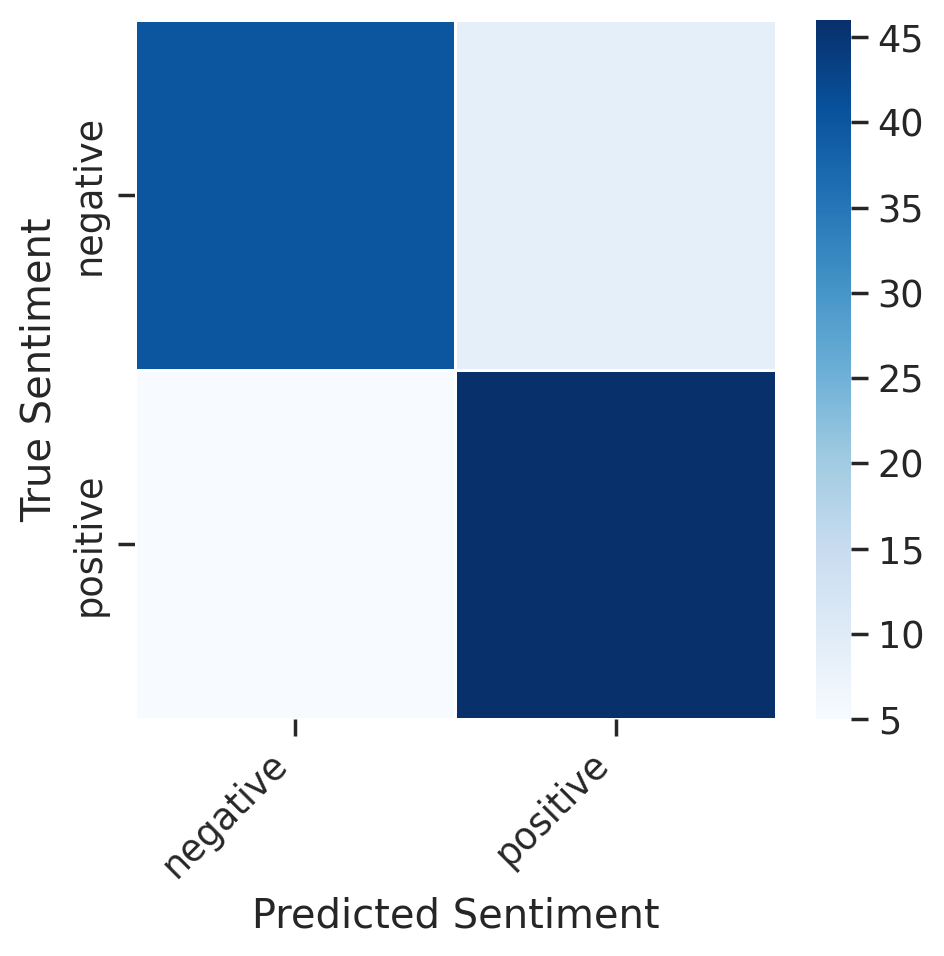

In [ ]:
sns.set(style='ticks', font_scale=1.2)
fig, ax = plt.subplots(figsize=(5,5))         # Sample figsize in inches
sns.heatmap(df_wide, linewidths=1, cmap='Blues',ax=ax)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Looks good! We can see that overall, our model is assigning the correct sentiment for each review.

## <font color='#2B4865'>Appendix</font>

##### <font color='#2B4865'>**Instructions on how to create a custom dataset**</font>

When fine-tuning a Transformer model, it is not strictly necessary to use one of the Datasets available at the Hub. There are a few ways to go about defining our datasets, by creating and loading them from local or remote datasets.

🤗 Datasets support several common data formats to load local datasets, such as **CSV & TSV**, **Text files**, **JSON & JSON Lines** and **Pickled DataFrames**, and they can be loaded with the ``load_dataset`` and the file type identifier. F.e., if we want to load a CSV file, we will make it as follows:

```
from datasets import load_dataset
load_dataset("csv", data_files="my_file.csv")
````

You may also want to use datasets that are stored in a remote server such as GitHub. It turns out that loading these files is as simple as doing so for local ones: we only need to point the ``data_files`` argument of ``load_dataset()`` to one or more URLs where the remote files are stored. For example, for the SQuAD-explorer dataset hosted on GitHub, we can just point data_files to the SQuAD-explorer-*.json URLs as follows:

```
base_url = "https://rajpurkar.github.io/SQuAD-explorer/dataset/"
dataset = load_dataset("json", data_files={"train": base_url + "train-v1.1.json", "validation": base_url + "dev-v1.1.json"}, field="data")
```

You can also create a HF Dataset from a Pandas dataFrame as follows:
```
from datasets import Dataset
import pandas as pd
df = pd.DataFrame({"a": [1, 2, 3]})
dataset = Dataset.from_pandas(df)
```

You can check more details about these functionalities [here](https://huggingface.co/course/chapter5/2?fw=pt).

In some scenarios, you may need to build a dataset from scratch, because you need to solve a certain NLP application and it does not exist. [In this link](https://huggingface.co/course/chapter5/5?fw=pt), you have a tutorial on how to create a corpus of GitHub issues, first by getting the data via the GitHub REST APLI, and then constructing the dataset. In this scenario, you will probably need to carry out the cleaning of the data.

## <font color='#2B4865'>Summary</font>

In this tutorial, we have covered the basics of 🤗 Transformers. We have learned the basic building blocks of a Transformer model, as well as how to use them to perform inference. We have also learned how to carry out the fine-tuning of a pre-trained model on a Sentiment Analysis task and a specific dataset.

In the next notebooks, we will leverage the knowledge gained here to solve two more NLP tasks that are a little more complicated than the one covered here.